In [5]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Literal
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from langchain_groq import ChatGroq
load_dotenv()


True

In [6]:
model= ChatGroq(
model="llama-3.3-70b-versatile",
temperature=0.5
)

In [12]:
class Review(BaseModel):
    sentiment:Literal["positive","negative"]=Field(..., description="The sentiment of the review")

class DiagnosisSchema(BaseModel):
    issue_type:Literal["bug","feature_request","other"]=Field(..., description="The type of issue")
    emotion:Literal["happy","sad","angry"]=Field(..., description="The emotion expressed in the review")
    urgency:Literal["low","medium","high"]=Field(..., description="The urgency of the issue")


In [13]:
structured_model=model.with_structured_output(Review)
structured_model2=model.with_structured_output(DiagnosisSchema)
# structured_model.invoke("I love this product!")

In [14]:
class ReviewState(TypedDict):

    review:str
    sentiment:Literal["positive","negative"]
    diagnosis:dict
    response:str

def get_sentiment(state:ReviewState)->Literal["positive","negative"]:
    prompt=f"For the following review, find out the sentiment: {state['review']}"
    sentiment=structured_model.invoke(prompt).sentiment
    return {"sentiment":sentiment}

#conditional nodes for next steps
def next_steps(state:ReviewState)->Literal["positive_response","run_diagnosis"]: 
    if state["sentiment"]=="positive":
        return "positive_response"
    else:
        return "run_diagnosis"

def positive_response(state:ReviewState)->str:
    response=model.invoke(f"Write a warm thanks message for the following review: {state['review']}")
    return {"response":response}

def run_diagnosis(state:ReviewState)->dict:
    prompt=f"For the following negative review, find out the issue type, emotion and urgency: {state['review']}"
    diagnosis=structured_model2.invoke(prompt)
    return {"diagnosis":diagnosis.model_dump()}

def negative_response(state:ReviewState)->dict:
    response=model.invoke(f"Write a apology response for the following negative review:\n {state['diagnosis']['issue_type']} - {state['diagnosis']['emotion']} - {state['diagnosis']['urgency']}")
    return {"response":response}



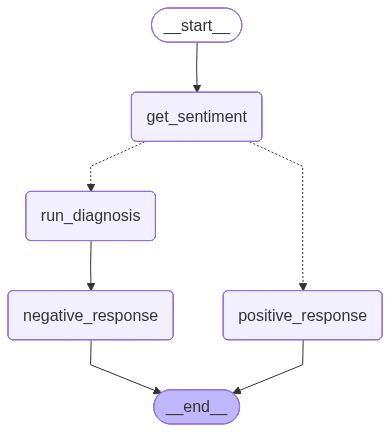

In [16]:
graph=StateGraph(ReviewState)
graph.add_node("get_sentiment",get_sentiment)
graph.add_node("positive_response",positive_response)
graph.add_node("run_diagnosis",run_diagnosis)
graph.add_node("negative_response",negative_response)


graph.add_edge(START,"get_sentiment")
graph.add_conditional_edges("get_sentiment",next_steps)
graph.add_edge("positive_response",END)
graph.add_edge("run_diagnosis","negative_response")
graph.add_edge("negative_response",END)

workflow=graph.compile()
workflow

In [17]:
initial_state={
    "review":"I absolutely love this product! It arrived on time, works perfectly, and has made my daily routine so much easier. Highly recommended!"
}
final_state=workflow.invoke(initial_state)

In [18]:
final_state

{'review': 'I absolutely love this product! It arrived on time, works perfectly, and has made my daily routine so much easier. Highly recommended!',
 'sentiment': 'positive',
 'response': AIMessage(content="Dear valued customer,\n\nWe are absolutely thrilled to hear that you're loving our product! We want to extend our warmest thanks for taking the time to share your wonderful review with us. It's fantastic to know that our product has made a positive impact on your daily routine and that it arrived on time, working perfectly as expected.\n\nYour kind words and high recommendation mean the world to us, and we're grateful for customers like you who appreciate our efforts to provide top-notch products and service. We're committed to continuing to deliver exceptional quality and convenience to our customers, and your feedback is invaluable in helping us achieve this goal.\n\nOnce again, thank you for your wonderful review and for choosing our product. We're honored to have customers like 

In [19]:
initial_state={
    "review":"I’m really disappointed — the device stopped working just two days after I bought it, and I need a replacement immediately because I rely on it for work!"
}
final_state=workflow.invoke(initial_state)
final_state

{'review': 'I’m really disappointed — the device stopped working just two days after I bought it, and I need a replacement immediately because I rely on it for work!',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'bug', 'emotion': 'sad', 'urgency': 'high'},
 'response': AIMessage(content='Here\'s a potential apology response:\n\n"Dear valued customer,\n\nWe\'re deeply sorry to hear that your experience with us was disappointing. It sounds like we fell short of meeting your expectations, and for that, we apologize. We take all feedback seriously and would like to make things right.\n\nCould you please provide more details about the issue you encountered, such as what specifically went wrong and how we can improve? Your input is invaluable in helping us identify areas where we need to grow.\n\nWe\'re committed to providing a better experience for all our customers, and we appreciate your feedback in helping us get there. If there\'s anything we can do to make up for the disappo